# Capstone Project - Portfolio Exercise Starbucks
 
## Project Definition 

The following is adapted from the Udacity exercise description.

### Background Information

The dataset provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their candidates. The data for this exercise consists of about 120,000 data points split in 2:1 ratio among training and test files. Each data point includes one column indicating whether or not an individual was sent a promotion for a specific product, and one column indicating whether or not that individual eventually purchased that product. Each individual also had seven additional features associated with them.

The training data is provided below.

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

## Problem Statement

The task is to use the training data to understand what patterns in V1-V7 (the training features) to indicate that a promotion should be provided to a user. The expected solution will be a function called **promotion_strategy**, likely utilizing some form of machine learning classification strategy in order to classify users into two categories: "send promotion" and "do not send promotion". The results will be compared with Starbucks's solution (see "Testing & Evaluation").

## Metrics

### Optimization Metrics

Specifically, the goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

Ratio of the number of purchasers in the promotion group to the total number of customers in the promotion group minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group.

* **Net Incremental Revenue (NIR)**

The total number of purchasers that received the promotion times 10 minus the number of promotions given times 0.15 minus the number of purchasers who were not given the promotion times 10.

### Testing & Evaluation Metrics

The success of the optimization strategy will be evaluated against Starbucks' promotion strategy. The strategy will be implemented within the **promotion_strategy** function and passed to the **test_results** function for evaluation.

There are four possible outomes relative to past data:

Table of actual promotion vs. predicted promotion customers.  

```

|   | Actual      |     |    | 
|---|-------------|-----|----|
| Predicted       | Yes | No |  
| Yes             | I   | II |  
| No              | III | IV | 
```

The metrics will only be compared for the individuals which Starbucks predicts should obtain the promotion - that is quadrants I and II here. Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equal participants.  

## Analysis

First we will read in the data below and examine how each variable or combination of variables along with a promotion influences the chance of purchasing. We will include visualizations of the relationships between variables, promotions and purchasing.

In [53]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./data/training.csv')

### Data Exploration

The first steps for data exploration are to view a sample of the data and calculate some descriptive statistics.

In [16]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [36]:
train_data.Promotion.value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [13]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


### Visualization

After viewing the descriptive statistics above for the various features V1-V7, it would be helpful also to visualize each of these features as a histogram to get a general sense of how the features are distributed.

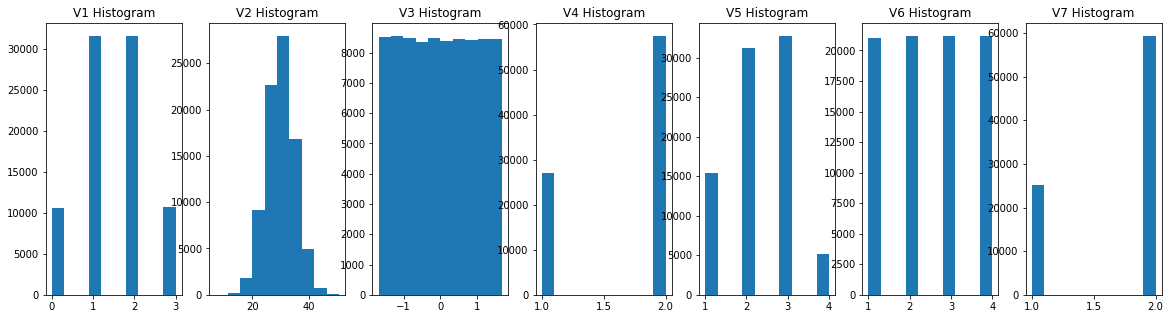

In [28]:
fig, ax = plt.subplots(1,7, figsize=(20, 5))
ax[0].hist(train_data.V1, bins=10)
ax[0].set_title('V1 Histogram')
ax[1].hist(train_data.V2, bins=10)
ax[1].set_title('V2 Histogram')
ax[2].hist(train_data.V3, bins=10)
ax[2].set_title('V3 Histogram')
ax[3].hist(train_data.V4, bins=10)
ax[3].set_title('V4 Histogram')
ax[4].hist(train_data.V5, bins=10)
ax[4].set_title('V5 Histogram')
ax[5].hist(train_data.V6, bins=10)
ax[5].set_title('V6 Histogram')
ax[6].hist(train_data.V7, bins=10)
ax[6].set_title('V7 Histogram')
plt.show()

Some observations, based on the descriptive statistics and histograms:
    - V1, V4, V5, V6 and V7 appear to be discretely distributed with values rangeing between 0 and 4 depending on the metric.
    - V2 appears to be approximately normally distributed around a mean of 30 or so, with standard deviation of about 5.
    - V3 appears to be uniformly distributed between approximately -1.7 and 1.7 with mean of around 0.

The next step will be to implement the optimization metrics as defined above (IRR and NIR) and calculate the values for Starbucks's solution on the training data to give us a benchmark for our classifiers.

In [31]:
def calc_irr(df):
    '''
    Ratio of the number of purchasers in the promotion group to the total number of customers
    in the promotion group minus the ratio of the number of purchasers in the non-promotional
    group to the total number of customers in the non-promotional group.
    '''
    num_purchasers_prom = len(df[(df['Promotion'] == 'Yes') & df['purchase']])
    tot_promo = len(df[df['Promotion'] == 'Yes'])
    
    num_purchasers_noprom = len(df[(df['Promotion'] == 'No') & df['purchase']])
    tot_no_promo = len(df[df['Promotion'] == 'No'])
    
    irr = num_purchasers_prom / tot_promo - num_purchasers_noprom / tot_no_promo
    
    return irr

In [32]:
calc_irr(train_data)

0.009454547819772702

In [33]:
def calc_nir(df):
    '''
    The total number of purchasers that received the promotion times 10
    minus the number of promotions given times 0.15
    minus the number of purchasers who were not given the promotion times 10.
    '''

    num_purchasers_prom = len(df[(df['Promotion'] == 'Yes') & df['purchase']])
    tot_promo = len(df[df['Promotion'] == 'Yes'])
    num_purchasers_noprom = len(df[(df['Promotion'] == 'No') & df['purchase']])
    
    nir = num_purchasers_prom * 10 - tot_promo * 0.15 - num_purchasers_noprom * 10
    
    return nir

In [34]:
calc_nir(train_data)

-2334.5999999999995

As we can see, the IRR for the training set is fairly low, only about 1%, although without industry context, it is unclear whether this is low relative to industry standard. This rate will be taken as our benchmark rate.

The NIR is also quite low, with a loss of over $2000 on the campaign. Given that the number of those who receive the promotion and the number who do not are fairly close (42364 vs. 42170), this metric is not skewed by a biased sample, and we would hope to be able to bring it above 0 with our solution, but at least above this benchmark metric of -2334.6.

## Methodology 

### Preprocessing

Now that we have explored and visualized the data, formulated a strategy and identified benchmarks, we must first preprocess the data in order to prepare it for implementing our strategy.

In [37]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [38]:
for col in train_data.columns:
    print('{} missing values in column {}'.format(train_data[col].isnull().sum(), col))

0 missing values in column ID
0 missing values in column Promotion
0 missing values in column purchase
0 missing values in column V1
0 missing values in column V2
0 missing values in column V3
0 missing values in column V4
0 missing values in column V5
0 missing values in column V6
0 missing values in column V7


We can see that there are no missing values in the data, and all of the features are numeric.

It is possible that the discrete features should be treated as categorical, but at this stage we cannot know for sure, so we will proceed by treating them as numeric and see where this gets us. We can treat them as categorical and create dummy features later if need be and see if it improves our results.

In order to implement a classification strategy, we will need to identify a target variable and consider `V1`-`V7` as our features.

We can ignore the `ID` field. Our target variable should be whether or not an individual **should** receive a promotion, which will be modeled as the set of individuals which **did** receive a promotion and **did** purchase as well as those users who **did not** receive a promotion and **did not** purchase. Users who **should not** receive a promotion will be those who **did** receive one and **did not** purchase as well as those who **did** receive one and **did not** purchase.

The reasoning behind this model is that those who purchased without receiving a promotion or did not purchase despite receiving one were not positively affected by the promotion enough to purchase, or would have purchased anyway. The others, it can't be said for sure, but there is the possibility that they were either encouraged to purchase based on the promotion or they would have purchased had they received one.

In [68]:
train_data['Send Promotion'] = train_data.apply(lambda row: 1 if (row.Promotion == 'Yes' and row.purchase)
                                                              or (row.Promotion == 'No' and not row.purchase)
                                                            else 0, axis=1)

In [70]:
features = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]

In [71]:
target = train_data[['Send Promotion']]

### Implementation & Refinement

Now that we have explored and preprocessed the data, we will implement and refine our classification strategy for determining who should receive the Starbucks promotion.

First we will need to split our training data into two sets, for training and testing our classifier, and create a reusable function which can train a given classifier, generate predictions for the training and testing set, and then calculate scores for each set of predictions as compared to the true value.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=0)

In [73]:
def train_predict(classifier, X_train, y_train, X_test, y_test):
    classifier = classifier.fit(X_train, y_train)
    
    preds_train = classifier.predict(X_train)
    preds_test = classifier.predict(X_test)
    
    acc_train = classifier.score(X_train, y_train)
    acc_test = classifier.score(X_test, y_test)
    
    return preds_train, preds_test, acc_train, acc_test

Now we have everything we need to begin classifying. We will attempt classification with the following three classifiers:
    - Naive Bayes (GaussianNB)
    - RandomForestClassifier
    - AdaBoostClassifier

In [74]:
classifiers = [GaussianNB(), RandomForestClassifier(), AdaBoostClassifier()]

for clf in classifiers:
    _, _, acc_train, acc_test = train_predict(clf, X_train, y_train, X_test, y_test)
    
    print("Training score: {}; Test score: {}".format(acc_train, acc_test))

Training score: 0.5085173501577287; Test score: 0.5092268382700861


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training score: 0.9685331230283911; Test score: 0.4940380429639444


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training score: 0.5136277602523659; Test score: 0.5000473171193338


We can see from the results above that our RandomForestClassifier is massively overtraining (with training score ~100% but testing score not much better than chance) and both of the other classifiers do no better than chance.

Since the GaussianNB classifier doesn't have much in the way of hyperparameters to optimize, we will attempt to refine and optimize the AdaBoostClassifier to see if we can improve our prediction significantly above chance levels, and more importantly to improve our NIR and IRR metrics over the benchmark values.

In [100]:
chosen_classifier = AdaBoostClassifier(n_estimators=300, learning_rate=0.8, random_state=0)

In [101]:
_, _, acc_train, acc_test = train_predict(chosen_classifier, X_train, y_train, X_test, y_test)
print("Training score: {}; Test score: {}".format(acc_train, acc_test))

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training score: 0.5178391167192429; Test score: 0.5030756127566953


We are not able to do significantly better than chance, regardless of the hyperparameters offered, but let's evaluate our promotion strategy regardless.

In [108]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    res = chosen_classifier.predict(df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']])
    promotion = np.array([('Yes' if x == 1 else 'No') for x in res])
    
    return promotion

## Results - Evaluation & Justification

Next we must evaluate our results using the `test_results` function provided and justify our decisions regarding implementation of this particular strategy as opposed to others.

In [109]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.01.

Your nir with this strategy is -466.85.
Approximately, the highest scores obtained at Udacity were: irr of 0.1 and an nir of 300.

 How did you do?


(0.01150240766862869, -466.8499999999999)

As we can see from our results, we were able to beat the random-assignment benchmark value for NIR listed above and come in line with the benchmark value for IRR, but did not reach the highest IRR and NIR values obtained at Udacity.

The decision to implement a classifier based on the features and target variable defined above was the most natural first attempt, though may not have been the optimal strategy for this project.

## Conclusion

Finally, we will reflect on the results achieved and identify areas for potential improvement.

### Reflection


Given that the classifiers implemented did not do much better than chance levels at predicting whether an individual was flagged for promotion, it is not surprising that the results were not phenomenal. It is also very possible that the initial decisions to consider the discrete features as numeric rather than categorical, or how to classify individuals into whether or not they should receive a promotion were not the best choices, but they were simple first-pass assumptions for this project, and the results were still able to beat random-assignment in NIR.

### Areas for Improvement

The first area for improvement I would attempt would be to define the discrete features as categorical variables and re-attempt classification with the new feature set.

The second area for improvement I would consider would be to re-evaluate the definition of the target variable. Perhaps only individuals who received the promotion should be considered for classification, based on whether or not they purchased. Perhaps individuals who did not receive the promotion but purchased anyway should also be considered, and still labeled as "No", but individuals who did not receive the promotion and did not purchase should be excluded from the data set, since they do not offer us very much information and were perhaps simply adding noise to the data.

The final area for improvement that I would consider would be to do a deeper dive into the classifier models and hyperparameter optimization, to see if there is a better model than the ones considered and possibly employ GridSearch on each of the classifiers to be sure we have the best set of hyperparameters for each. I would only pursue this path after exploring the first two areas of improvement, since a more well-defined problem will always yield better results than a fancy algorithm with noisy data and an ill-defined task.